In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [23]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 100
batch_size = 100
learning_rate = 0.01

S_G=5
M_train=2000

In [24]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


train_subset_index=list(range(M_train))

train_subset_dataset=Subset(train_dataset, train_subset_index)


# Data loader
train_loader = DataLoader(dataset=train_subset_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_loader_1=DataLoader(dataset=train_subset_dataset, batch_size=1)

In [25]:
labels_to_investigate=[0,1,2,3,4]

In [26]:
import copy

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_tr=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_tr.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_ts=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_ts.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

G_subset_tr=Subset(train_dataset, G_ind_tr)
G_subset_ts=Subset(test_dataset, G_ind_ts)

G_loader_tr = DataLoader(dataset=G_subset_tr, batch_size=1, shuffle=False)
G_loader_ts = DataLoader(dataset=G_subset_ts, batch_size=1, shuffle=False)

In [27]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [28]:
model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

init_grads_tr=[]
init_grads_ts=[]

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)


for image,label in G_loader_tr:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_tr.append(init_grad)

for image,label in G_loader_ts:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    optimizer.zero_grad()
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_ts.append(init_grad)

def train_epoch(GETGRADIENTS=False):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    r_loss=loss.item()
    if GETGRADIENTS:
        dots_tr=[]
        for k,(image, label) in enumerate(G_loader_tr):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_tr.append(np.dot(init_grads_tr[k],gradient))
        dots_ts=[]
        for k,(image, label) in enumerate(G_loader_ts):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_ts.append(np.dot(init_grads_ts[k],gradient))

        return r_loss, dots_tr,dots_ts
    else:
        return loss.item()
    
def get_densities(train_dots,test_dots):
    from scipy.stats import gaussian_kde

    x_tr=np.linspace(min(0,min(train_dots)-0.05),max(max(train_dots)*1.05,1),100)
    x_ts=np.linspace(min(0,min(test_dots)-0.05),max(max(test_dots)*1.05,1),100)

    tr_densities=[]
    for n in range(len(labels_to_investigate)):
        tr_densities.append(gaussian_kde(train_dots[n*S_G:(n+1)*S_G])(x_tr))

    ts_densities=[]
    for n in range(len(labels_to_investigate)):
        ts_densities.append(gaussian_kde(test_dots[n*S_G:(n+1)*S_G])(x_ts))
        
    return tr_densities,ts_densities,x_tr,x_ts

train_loss = []
dots_tr = []
dots_ts = []
dots_den_tr=[]
den_x_tr=[]
dots_den_ts=[]
den_x_ts=[]
epoch_list=[]

for epoch in range(num_epochs):
    if (epoch+1)%2==0:
        trainloss, ds_tr,ds_ts = train_epoch(GETGRADIENTS=True)
        train_loss.append(trainloss)
        dots_tr.append(ds_tr)
        dots_ts.append(ds_ts)
        epoch_list.append(epoch+1)
    if (epoch+1)%25==0:
        tr,ts,tr_x,ts_x=get_densities(dots_tr[-1],dots_ts[-1])
        dots_den_tr.append(tr)
        dots_den_ts.append(ts)
        den_x_tr.append(tr_x)
        den_x_ts.append(ts_x)
    else:
        trainloss=train_epoch()
    print('Epoch: {} TrainLoss: {:.3f}'.format(epoch+1,trainloss))

Epoch: 1 TrainLoss: 2.077
Epoch: 2 TrainLoss: 1.614
Epoch: 3 TrainLoss: 1.501
Epoch: 4 TrainLoss: 1.256
Epoch: 5 TrainLoss: 1.127
Epoch: 6 TrainLoss: 0.875
Epoch: 7 TrainLoss: 0.891
Epoch: 8 TrainLoss: 0.842
Epoch: 9 TrainLoss: 0.710
Epoch: 10 TrainLoss: 0.722
Epoch: 11 TrainLoss: 0.661
Epoch: 12 TrainLoss: 0.596
Epoch: 13 TrainLoss: 0.776
Epoch: 14 TrainLoss: 0.569
Epoch: 15 TrainLoss: 0.531
Epoch: 16 TrainLoss: 0.521
Epoch: 17 TrainLoss: 0.549
Epoch: 18 TrainLoss: 0.462
Epoch: 19 TrainLoss: 0.538
Epoch: 20 TrainLoss: 0.419
Epoch: 21 TrainLoss: 0.485
Epoch: 22 TrainLoss: 0.404
Epoch: 23 TrainLoss: 0.452
Epoch: 24 TrainLoss: 0.523
Epoch: 25 TrainLoss: 0.523
Epoch: 26 TrainLoss: 0.408
Epoch: 27 TrainLoss: 0.317
Epoch: 28 TrainLoss: 0.273
Epoch: 29 TrainLoss: 0.419
Epoch: 30 TrainLoss: 0.376
Epoch: 31 TrainLoss: 0.300
Epoch: 32 TrainLoss: 0.349
Epoch: 33 TrainLoss: 0.425
Epoch: 34 TrainLoss: 0.423
Epoch: 35 TrainLoss: 0.371
Epoch: 36 TrainLoss: 0.318
Epoch: 37 TrainLoss: 0.378
Epoch: 38 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


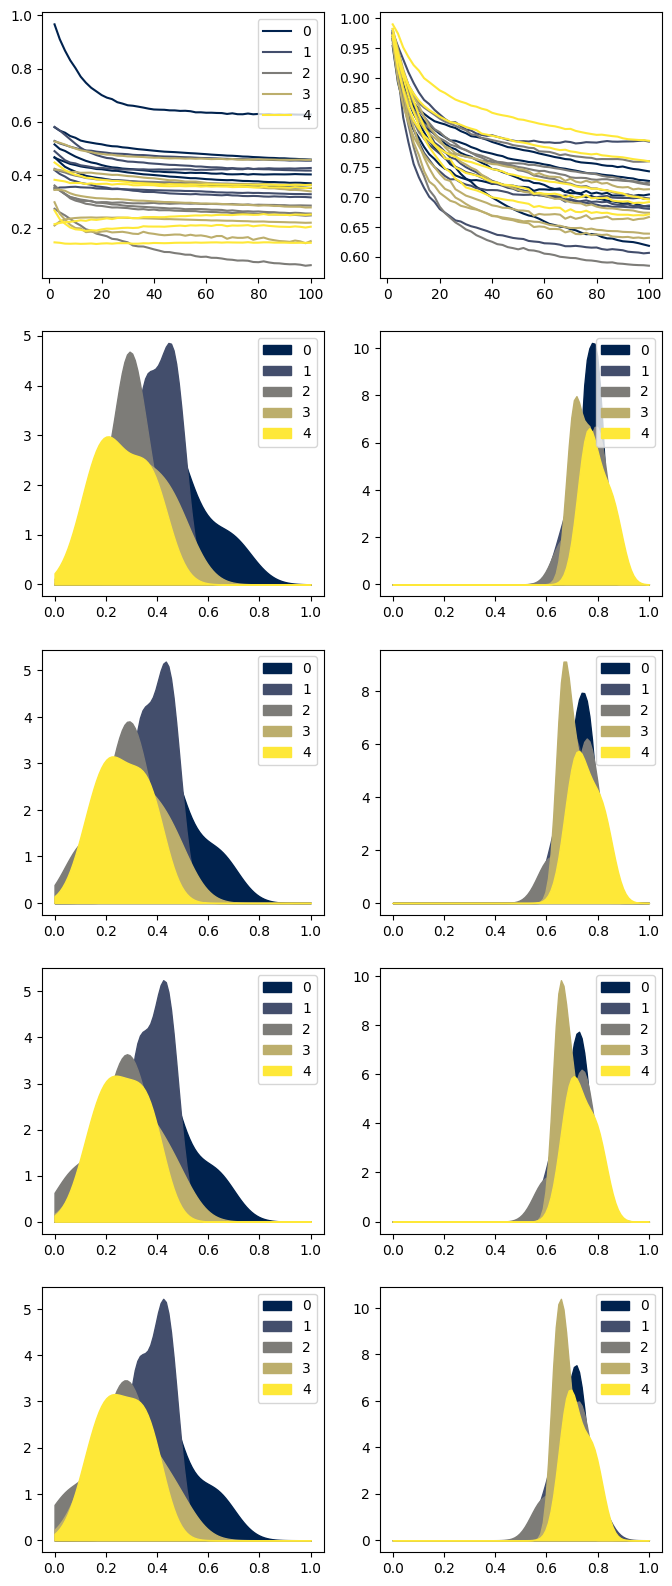

In [29]:
N=len(epoch_list)

colors = plt.cm.cividis(np.linspace(0, 1, len(labels_to_investigate)))

fig,axs=plt.subplots(len(dots_den_tr)+1,2,figsize=(8,4*(len(dots_den_tr)+1)))

for i in range(len(labels_to_investigate)):
    for j in range(S_G):
        if j==0:
            axs[0,0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(labels_to_investigate[i]))
            axs[0,1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(labels_to_investigate[i]))
        else:
            axs[0,0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i])
            axs[0,1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i])
axs[0,0].legend()
axs[1,1].legend()

for i,dens in enumerate(dots_den_tr):
    for j,den in enumerate(dens):
        axs[i+1,0].fill_between(den_x_tr[i],den,color=colors[j],label=str(j))
    axs[i+1,0].legend()

for i,dens in enumerate(dots_den_ts):
    for j,den in enumerate(dens):
        axs[i+1,1].fill_between(den_x_ts[i],den,color=colors[j],label=str(j))
    axs[i+1,1].legend()

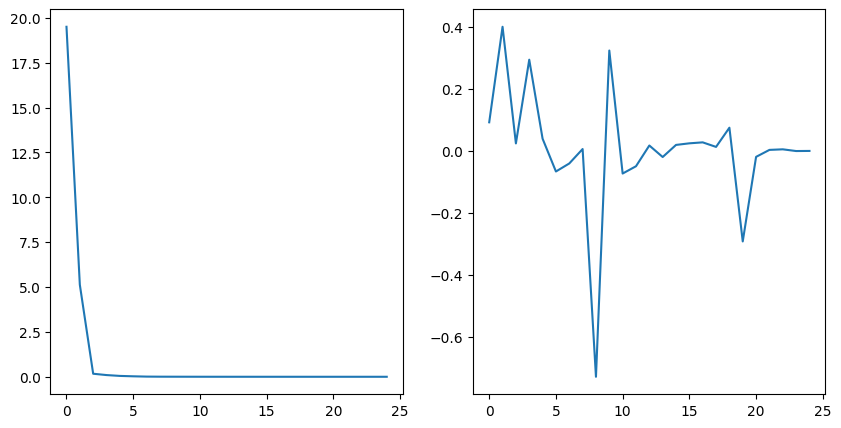

In [30]:
grad_matrix=[]
for image,label in G_loader_ts:
        image = image.reshape(-1, 28*28)
        output=model(image)
        loss = criterion(output,label)
        loss.backward()
        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        gradient+=model.input_layer.bias.grad.tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        gradient+=model.output_layer.bias.grad.tolist()
        gradient=np.array(gradient)
        gradient=gradient/np.linalg.norm(gradient)
        grad_matrix.append(gradient)

ker_matrix=[]
for vec1 in grad_matrix:
    row=[]
    for vec2 in grad_matrix:
          row.append(np.dot(vec1,vec2))
    ker_matrix.append(row)

evals,evectors=np.linalg.eig(ker_matrix)

fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].plot(np.arange(len(evals)),evals)

axs[1].plot(np.arange(len(evectors[0])),evectors[0])

In [31]:
S_G=20
labels_to_investigate=[0,1]
learning_rate=0.1

In [32]:
import copy

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_tr=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_tr.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_ts=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_ts.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

G_subset_tr=Subset(train_dataset, G_ind_tr)
G_subset_ts=Subset(test_dataset, G_ind_ts)

G_loader_tr = DataLoader(dataset=G_subset_tr, batch_size=1, shuffle=False)
G_loader_ts = DataLoader(dataset=G_subset_ts, batch_size=1, shuffle=False)

In [33]:
model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)


criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)


def train_epoch():
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()
    
epoch_list=[]

for epoch in range(num_epochs):
    trainloss=train_epoch()
    print('Epoch: {} TrainLoss: {:.3f}'.format(epoch+1,trainloss))

X=[]
for image,label in G_loader_tr:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    gradient=[]
    gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
    gradient+=model.input_layer.bias.grad.tolist()
    gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
    gradient+=model.output_layer.bias.grad.tolist()
    gradient=np.array(gradient)
    gradient=gradient/np.linalg.norm(gradient)
    X.append(gradient)

Epoch: 1 TrainLoss: 1.114
Epoch: 2 TrainLoss: 0.634
Epoch: 3 TrainLoss: 0.521
Epoch: 4 TrainLoss: 0.457
Epoch: 5 TrainLoss: 0.438
Epoch: 6 TrainLoss: 0.450
Epoch: 7 TrainLoss: 0.394
Epoch: 8 TrainLoss: 0.308
Epoch: 9 TrainLoss: 0.250
Epoch: 10 TrainLoss: 0.246
Epoch: 11 TrainLoss: 0.216
Epoch: 12 TrainLoss: 0.216
Epoch: 13 TrainLoss: 0.325
Epoch: 14 TrainLoss: 0.186
Epoch: 15 TrainLoss: 0.170
Epoch: 16 TrainLoss: 0.132
Epoch: 17 TrainLoss: 0.271
Epoch: 18 TrainLoss: 0.175
Epoch: 19 TrainLoss: 0.200
Epoch: 20 TrainLoss: 0.243
Epoch: 21 TrainLoss: 0.155
Epoch: 22 TrainLoss: 0.179
Epoch: 23 TrainLoss: 0.108
Epoch: 24 TrainLoss: 0.158
Epoch: 25 TrainLoss: 0.153
Epoch: 26 TrainLoss: 0.116
Epoch: 27 TrainLoss: 0.137
Epoch: 28 TrainLoss: 0.092
Epoch: 29 TrainLoss: 0.117
Epoch: 30 TrainLoss: 0.089
Epoch: 31 TrainLoss: 0.103
Epoch: 32 TrainLoss: 0.122
Epoch: 33 TrainLoss: 0.078
Epoch: 34 TrainLoss: 0.084
Epoch: 35 TrainLoss: 0.113
Epoch: 36 TrainLoss: 0.073
Epoch: 37 TrainLoss: 0.051
Epoch: 38 

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

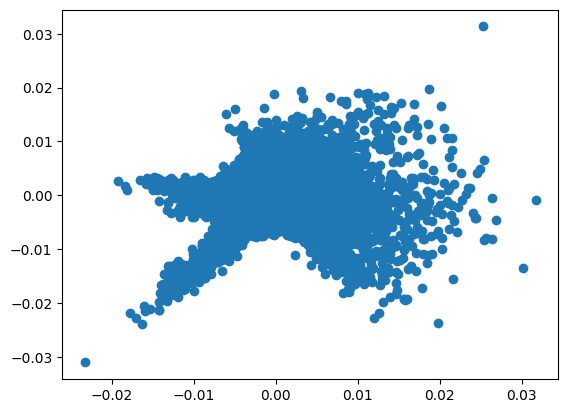

In [35]:
plt.scatter(pca.components_[0],pca.components_[1])